In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
import tensorflow as tf

In [0]:
os.makedirs('model_checkpoints', exist_ok=True)
os.makedirs('plots', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

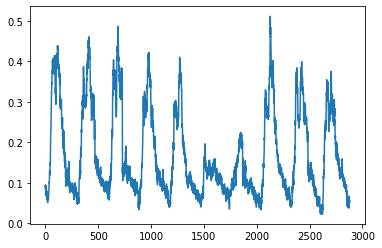

In [0]:
plt.plot(df[:10*288])

In [0]:
weekday_power_series = []
weekend_power_series = []
for i in tqdm(range(0, len(df)-7, 7*288)):
  weekday_power_series += df['W'][i:i+5*288].tolist()
  weekend_power_series += df['W'][i+5*288:i+7*288].tolist()

100%|██████████| 50/50 [00:00<00:00, 1142.38it/s]


In [0]:
len(weekday_power_series)

72000

In [0]:
len(df) - len(weekday_power_series)

28800

In [0]:
weekday_power_series = np.array(weekday_power_series)
weekend_power_series = np.array(weekend_power_series)

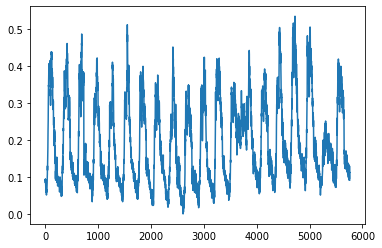

In [0]:
plt.plot(weekday_power_series[:288*20])

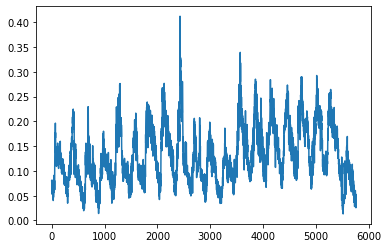

In [0]:
plt.plot(weekend_power_series[:288*20])

In [0]:
class weekday_args:
  def __init__(self):
    self.val_start = 12*24*150
    self.test_start = 12*24*200
    self.train_seq_len = 12*24*10
    self.val_seq_len = 12*24
    
    self.conv_num_channels = 128
    self.kernel_size = 12
    self.dilation_rates = [2**i for i in range(8)] 
    self.dropout = 0.2
    self.batch_size = 256
    self.num_epochs = 25
    
    self.save_folder = 'weekday_forecast_Dilated_CNN'

In [0]:
args = weekday_args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder + '/logs_dir', exist_ok=True)
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_arr = weekday_power_series[: args.val_start]
val_arr = weekday_power_series[args.val_start: args.test_start]
test_arr = weekday_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)

100%|██████████| 11233/11233 [00:01<00:00, 6739.07it/s]


In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
#best_val = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', save_freq='epoch')

In [0]:
history_seq = tf.keras.layers.Input(shape=(args.train_seq_len, 1))
x = history_seq

for dilation_rate in args.dilation_rates:
    x = tf.keras.layers.Conv1D(filters = args.convnum_channels,
              kernel_size = args.kernel_size, 
              padding = 'causal',
              dilation_rate = dilation_rate)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(args.dropout)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(args.val_seq_len)(x)

model = tf.keras.Model(history_seq, x)

In [0]:
model.compile(loss='mean_squared_error', optimizer=sgd)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2880, 100)         1300      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2880, 100)         120100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2880, 100)         120100    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2880, 100)         120100    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2880, 100)         120100    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2880, 100)         120100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2880, 100)         1

In [0]:
history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/25
 48/157 [========>.....................] - ETA: 5:05 - loss: 0.0420

In [0]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.save_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

In [0]:
X_test, y_test = make_windows(test_arr)

100%|██████████| 12097/12097 [00:01<00:00, 8648.36it/s]


In [0]:
y_pred = model.predict(X_test)

NameError: ignored

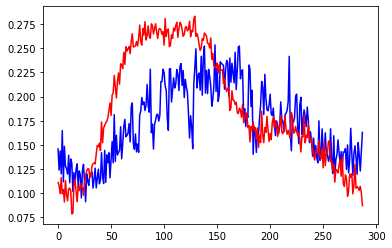

In [0]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred[0], color = 'red')
plt.savefig('plots/' + args.save_folder + '/test_weekend_pred.png')

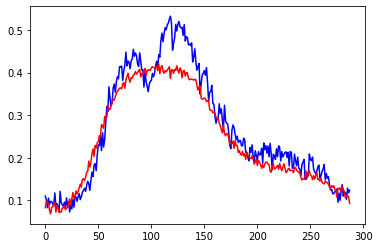

In [0]:
plt.plot(y_test[12*24*2], color = 'blue')
plt.plot(y_pred[12*24*2], color = 'red')
plt.savefig('plots/'  + args.save_folder + '/test_weekday_pred.png')

In [0]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

In [0]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results_final.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results_final.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

In [0]:
results.to_csv('forecasts/full_testing_length/results_final.csv', index=False)

In [0]:
class weekend_args:
  def __init__(self):
    self.val_start = 12*24*60
    self.test_start = 12*24*80
    self.train_seq_len = 12*24*4
    self.val_seq_len = 12*24
    
    self.conv_num_channels = 128
    self.kernel_size = 12
    self.dilation_rates = [2**i for i in range(8)] 
    self.dropout = 0.2
    self.batch_size = 256
    self.num_epochs = 25
    
    self.save_folder = 'weekday_forecast_Dilated_CNN'

In [0]:
args = weekend_args()

In [0]:
os.makedirs('plots/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder, exist_ok=True)
os.makedirs('model_checkpoints/' + args.save_folder + '/logs_dir', exist_ok=True)
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_arr = weekend_power_series[: args.val_start]
val_arr = weekend_power_series[args.val_start: args.test_start]
test_arr = weekend_power_series[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data[i - train_seq_len: i].T.tolist())
        y.append(data[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_arr)
X_val, y_val = make_windows(val_arr)

100%|██████████| 12673/12673 [00:01<00:00, 9759.74it/s]


In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.1, decay=1e-2, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2)
#best_val = tf.keras.callbacks.ModelCheckpoint('model_checkpoints/' + args.save_folder + '/model_{epoch:02d}.h5', save_best_only=True, mode='min', save_freq='epoch')

In [0]:
history_seq = tf.keras.layers.Input(shape=(args.train_seq_len, 1))
x = history_seq

for dilation_rate in args.dilation_rates:
    x = tf.keras.layers.Conv1D(filters = args.convnum_channels,
              kernel_size = args.kernel_size, 
              padding = 'causal',
              dilation_rate = dilation_rate)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(args.dropout)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(args.val_seq_len)(x)

model = tf.keras.Model(history_seq, x)

In [0]:
model.compile(loss='mean_squared_error', optimizer=sgd)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1440, 100)         1300      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1440, 100)         120100    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1440, 100)         120100    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1440, 100)         120100    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1440, 100)         120100    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1440, 100)         120100    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1440, 100)        

In [0]:
history = model.fit(X_train, y_train, batch_size = args.batch_size, epochs = args.num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/25
72/82 [=========================>....] - ETA: 32s - loss: 0.0304

In [0]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.save_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

In [0]:
X_test, y_test = make_windows(test_arr)

100%|██████████| 12097/12097 [00:01<00:00, 8648.36it/s]


In [0]:
y_pred = model.predict(X_test)

NameError: ignored

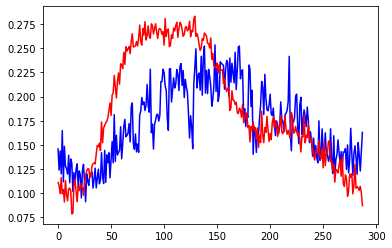

In [0]:
plt.plot(y_test[0], color = 'blue')
plt.plot(y_pred[0], color = 'red')
plt.savefig('plots/' + args.save_folder + '/test_weekend_pred.png')

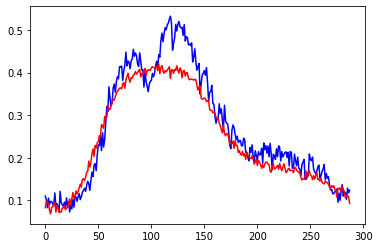

In [0]:
plt.plot(y_test[12*24*2], color = 'blue')
plt.plot(y_pred[12*24*2], color = 'red')
plt.savefig('plots/'  + args.save_folder + '/test_weekday_pred.png')

In [0]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

In [0]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results_final.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results_final.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

In [0]:
results.to_csv('forecasts/full_testing_length/results_final.csv', index=False)

In [0]:
with open('forecasts/full_testing_length/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()